# PROJETO FINAL 
## Uma Abordagem Automática para Detecção de Grupos Públicos do WhatsApp

- Disciplina: Natural Language Processing
- Daniel Pimentel Kansaon


## Objetivos

## Organização do Trabalho

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [497]:
!unzip /content/drive/MyDrive/ColabNotebooks/fast_skip_s100.zip -d ./sample_data/

Archive:  /content/drive/MyDrive/ColabNotebooks/fast_skip_s100.zip
replace ./sample_data/skip_s100.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# BIBLIOTECAS

In [1]:
import json
import gzip
import pandas as pd
import re
import string
import os
from tqdm import tqdm
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize

import plotly.express as px

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as util

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as util
from keras.models import Sequential
from keras.layers import Embedding, InputLayer
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Flatten

from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import MaxPooling1D

from keras.layers import Input
from sklearn.utils import class_weight
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pip2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plot
#import seaborn as sns; sns.set_theme()
import plotly.graph_objects as go

from wordcloud import WordCloud 

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will

# CONSTANTES

In [135]:
FILE_PATH_ZAP = './scripts/final_data/db_grupos_de_zap.json.gz'
FILE_PATH_WHATS = './scripts/final_data/db_grupos_whats.json.gz'
FILE_PATH_CATEG = './scripts/final_data/categories.csv'

EMBEDDING_SIZE = 100
EMBEDDING_PATH = '/home/daniel/Downloads'
K_FOLD = 5
N_CLASSES = 20

STOP_WORDS = set(stopwords.words('portuguese'))

# MÉTODOS UTILIZADOS

In [3]:
def read_data(path):
    with gzip.open(path, 'r') as fin:      
        json_bytes = fin.read()  

        json_str = json_bytes.decode('utf-8')            
        data = json.loads(json_str)
    
    return data

## Leitura dos Dados

In [4]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [5]:
def process_text(text):
    text = remove_emoji(text) #REMOVE EMOJIS
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS]) #REMOVE STOPWORDS
    text = text.translate(str.maketrans('', '', string.punctuation)) #REMOVE PONTUAÇÃO
    text = ' '.join([word for word in text.split() if not word.isdigit()]) #REMOVE DIGITOS
    
    return text.lower()

In [6]:
def get_df_data(data):
    desc = [data[i]['title'] + ' ' + data[i]['description'] for i in range(0, len(data))]
    cat = [d['category'] for d in data]
    return pd.DataFrame({'description': desc, 'category': cat})

#https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb#scrollTo=AXhAERVeXhmZ

## Função para Matriz de Confusão

In [7]:
def plot_confusion_matrix(model, x_train, y_train):    
    y_pred = np.argmax(x_train, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    #print(classification_report(y_true, y_pred))
    
    #classes = list(range(1, N_CLASSES))
    fig, ax = plt.subplots(figsize=(14, 14))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=ALL_CATEGORIES, yticklabels=ALL_CATEGORIES,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,str(round(cm[i, j], 2)).strip(), ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

## Função para plotar uma CDF

In [8]:
def plot_cdf_n_curves(list_curve, label_curve, x_label, chart_path, isLog=True):
    n = len(list_curve)
    ecdf_list = list()
    
    for k in range(n):
        list_curve[k].sort()
        cdf = ECDF(list_curve[k])
        ecdf_list.append(cdf)
    
    fig, ax = plt.subplots()
    plt.grid()
    for k in range(n):
        plt.plot(ecdf_list[k].x, ecdf_list[k].y, label=label_curve[k], linewidth=2)
   
    plt.legend(loc='lower right')
    if isLog:
        chart_path = chart_path+'_log'
        ax.set_xscale('log')
        
    ax.set_xlabel(x_label)
    ax.set_ylabel('CDF')
    plt.tight_layout()
    plot.show()

In [9]:
def plot_training_performance(acc, val_acc, title):
    plt.figure(figsize=(6,4))
    plt.plot(acc)
    plt.plot(val_acc)

    plt.title(title)
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')

    plt.legend(['Treino', 'Teste'], loc="lower right")
    plt.show()

In [10]:
def plot_word_cloud(texts):
    long_string = ','.join(texts)
    long_string = long_string.replace('bem vindo', '').replace('grupo', '').replace('aqui','')
    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=1000, height=500)
    
    # Generate a word cloud
    wordcloud.generate(long_string)

    # Visualize the word cloud
    #wordcloud.to_file('words.png')
    return wordcloud.to_image()

# BASE DE DADOS

In [73]:
df_base1 = get_df_data(read_data(FILE_PATH_ZAP))
df_base2 = get_df_data(read_data(FILE_PATH_WHATS))

## Pré-Processamento

In [74]:
#Remove stopwords, números, pontuações e emojis.
df_base1['description'] = df_base1['description'].apply(process_text)
df_base2['description'] = df_base2['description'].apply(process_text)

In [75]:
#Remove grupos com descrição nula
df_base1.drop(index=df_base1[df_base1['description'] == ''].index, inplace=True)
df_base2.drop(index=df_base2[df_base2['description'] == ''].index, inplace=True)

In [72]:
#Remove grupos duplicados
df_base1 = df_base1.drop_duplicates()
df_base2 = df_base2.drop_duplicates()

## Volume das Bases de Dados

In [76]:
print("Dataset 1- Total: ", len(df_base1))
print("Dataset 2- Total: ", len(df_base2))
print("Total Categorias: ", len(Counter(df_base1['category'])))

Dataset 1- Total:  17855
Dataset 2- Total:  112606
Total Categorias:  21


## Distribuição das Categorias

In [16]:
qtd_cat_base1 = Counter(df_base1['category'])
qtd_cat_base2 = Counter(df_base2['category'])

In [17]:
df1 = pd.DataFrame({"Dados": ['Base 1' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base1.keys()), "Quantidade": list(qtd_cat_base1.values())})
df2 = pd.DataFrame({"Dados": ['Base 2' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base2.keys()), "Quantidade": list(qtd_cat_base2.values())})

fig = px.bar(pd.concat([df1, df2]), color='Dados', y='Categoria', x='Quantidade')
fig.show()

## Detalhamento de Cada Classe

In [36]:
categ_desc = pd.read_csv(FILE_PATH_CATEG, sep=';')
fig = go.Figure(data=[go.Table(header=dict(values=['Categoria', 'Descrição']),
                 cells=dict(values=[list(categ_desc['categoria']), list(categ_desc['descricao'])]))
                     ])
fig.show()

## Distribuição das Categorias
- 80% das categorias do dataset 1 tem menos de 1000 grupos
- 70% das categorias do dataset 2 mais de 1000 grupos

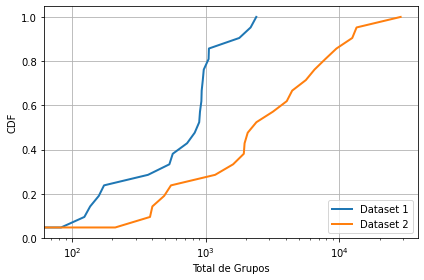

In [37]:
cdf_db1 = list(qtd_cat_base1.values())
cdf_db2 = list(qtd_cat_base2.values())

plot_cdf_n_curves([cdf_db1, cdf_db2], ['Dataset 1', 'Dataset 2' ], 'Total de Grupos', 'Categoria', isLog=True)

## Núvem de Termos

## Dataset 1

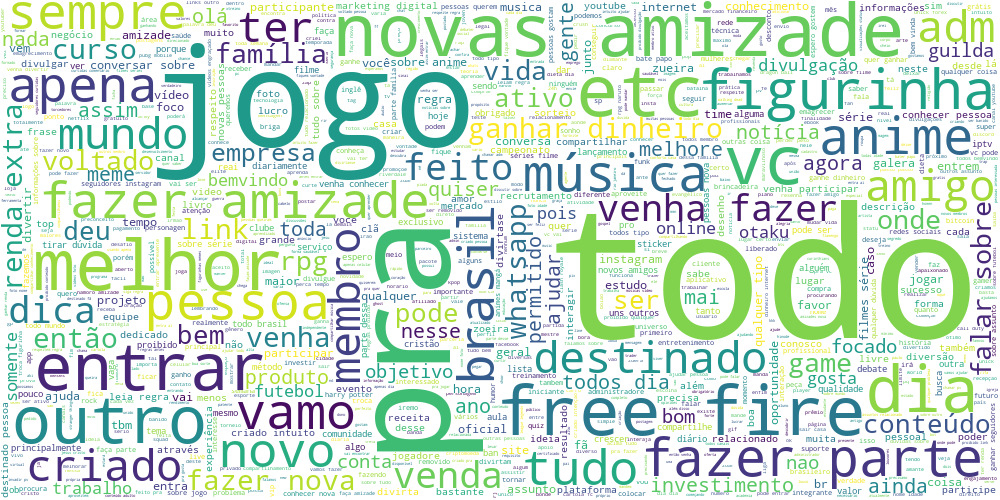

In [55]:
plot_word_cloud(df_base1['description'])

## Dataset 2

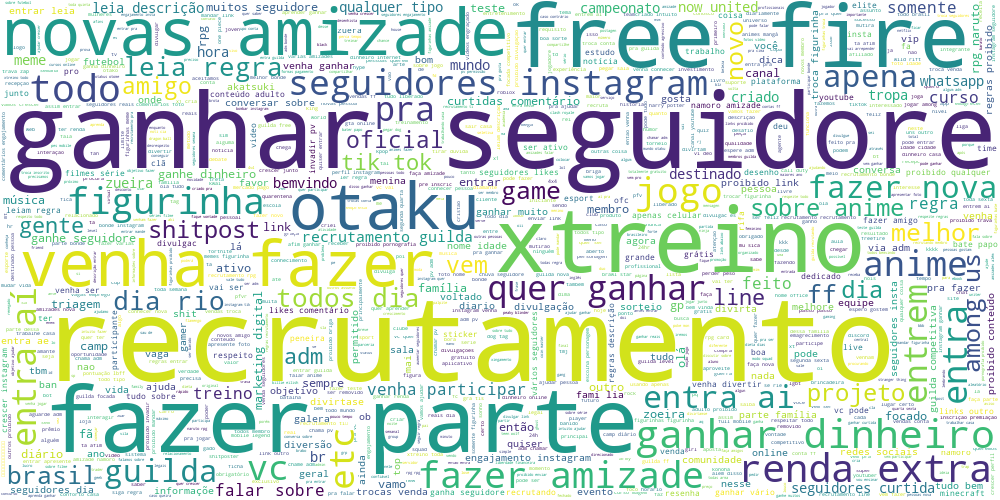

In [56]:
plot_word_cloud(df_base2['description'])

# PREPARAÇÃO DOS DADOS

In [120]:
#df_base1.drop(index=df_base1[df_base1['category'] == 'amizade'].index, inplace=True)
#df_base2.drop(index=df_base2[df_base2['category'] == 'amizade'].index, inplace=True)

#df_base1.loc[(df_base1.category == 'empregos e profissões'),'category']='ganhar dinheiro e empregos'
#df_base2.loc[(df_base2.category == 'empregos e profissões'),'category']='ganhar dinheiro e empregos'

#df_base1 = df_base1[df_base1['category'].isin(catego)]
#df_base2 = df_base2[df_base2['category'].isin(catego)]


## Tokenizar as sentences

In [121]:
all_descriptions = list(df_base1['description'])
all_descriptions.extend(list(df_base2['description']))

word_tokenizer = Tokenizer(split = ' ')
word_tokenizer.fit_on_texts(all_descriptions)

MAX_WORDS_SENTENCES = 85

SENTENCES_BASE1 = word_tokenizer.texts_to_sequences(df_base1['description']) 
SENTENCES_BASE1 = pad_sequences(SENTENCES_BASE1, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

SENTENCES_BASE2 = word_tokenizer.texts_to_sequences(df_base2['description']) 
SENTENCES_BASE2 = pad_sequences(SENTENCES_BASE2, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

In [122]:
maior = 0
for c in all_descriptions:
    if maior < len(c.split(' ')):
        maior = len(c.split(' '))
        
print("Maior Sentença: ", maior)

Maior Sentença:  82


In [123]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
print('Tamanho do Vocabulário: ', VOCABULARY_SIZE)

Tamanho do Vocabulário:  118880


## Tokenizar a Saída (classes)

In [127]:
ALL_CATEGORIES = list(set(df_base1['category']))
CATEGORY_BASE1 = [ALL_CATEGORIES.index(cat) for cat in df_base1['category']] 
CATEGORY_BASE2 = [ALL_CATEGORIES.index(cat) for cat in df_base2['category']] 

print('ALL: ', ALL_CATEGORIES)
print('Total: ', len(ALL_CATEGORIES))

ALL:  ['ganhar dinheiro', 'notícias', 'educação e estudo', 'games e jogos', 'redes sociais', 'fãs', 'esportes e academia', 'receitas', 'figurinhas e stickers', 'memes engraçados e zoeira', 'carros e motos', 'amor e romance', 'festas, baladas e eventos', 'religião', 'política', 'filmes e séries', 'música', 'tv, desenhos e animes', 'saúde, emagrecimento e beleza', 'frases e mensagens']
Total:  20


In [128]:
class_weights_db1 = dict(zip(np.unique(CATEGORY_BASE1), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE1), y=CATEGORY_BASE1)))
class_weights_db2 = dict(zip(np.unique(CATEGORY_BASE2), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE2), y=CATEGORY_BASE2)))

In [129]:
CATEGORY_BASE1 = util.np_utils.to_categorical(CATEGORY_BASE1, N_CLASSES)
CATEGORY_BASE2 = util.np_utils.to_categorical(CATEGORY_BASE2, N_CLASSES)

print('\nSHAPE: ', CATEGORY_BASE1.shape)
print('SHAPE: ', CATEGORY_BASE2.shape)


SHAPE:  (17855, 20)
SHAPE:  (112606, 20)


# Carregar Embeddings


In [130]:
def load_word_embedding(word_index, dimension_embedding):
    dic_embedding = {}
    
    file_embedding = open(os.path.join(EMBEDDING_PATH, "skip_s{}.txt".format(dimension_embedding)), encoding='utf-8')
    
    #Carregando os WordEmbeddings para um dicionario
    for line in tqdm(file_embedding):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefficient = np.asarray(values[1:], dtype='float32')
        dic_embedding[word] = coefficient
            
    file_embedding.close()
    
    #Cria a matrix com em que serão carregados os embeddings
    matrix_embedding = np.zeros((VOCABULARY_SIZE, dimension_embedding))
    
    for word, i in word_index.items():
        if i >= VOCABULARY_SIZE:
            continue
        
        vector_embedding = dic_embedding.get(word)
        
        if vector_embedding is not None:
            matrix_embedding[i] = vector_embedding

    return matrix_embedding

In [131]:
MATRIX_EMBEDDING = load_word_embedding(word_tokenizer.word_index, EMBEDDING_SIZE)

929607it [00:41, 22334.20it/s]


# CLASSIFICAÇÃO

In [132]:
#https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/intervalo-de-confianca-distribuicao-t-de-student/

def calc_conf_interval(v_validation):
    tbl_t_95 = 2.776 #Valor na tabela T-Student (4 graus de liberdade)
    mean = np.mean(v_validation, dtype=np.float64)
    std = np.std(v_validation)
        
    return [mean, (mean - (tbl_t_95 * std)), (mean + (tbl_t_95 * std)), tbl_t_95 * std]

In [58]:
def execute_logistic_regression(texts_words, y_class, weight):    
    accuracy_train = []
    accuracy_test = []
    macro1_train = []
    macro1_test = []
    weight_f1_test = []
    
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)
    
    #Vectoriza os textos, transformando em vetores de números, que representam as frequências
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)   
    
    #Executa a validação cruzada com 5 Folds
    for train_index, test_index in skf.split(texts_words, y_class): 
        
        model_logc = LinearSVC()
        #Cria o modelo
        #model_logc = LogisticRegression(solver='newton-cg', class_weight=weight)
     
        #Cria o pipeline para executar o método
        pipe_logc= Pipeline([('vectorizer', vectorizer), ('model_logc', model_logc)])
        
        #Treina e testa salvando os resultados
        pipe_logc.fit(np.array(texts_words)[train_index], np.array(y_class)[train_index])
        accuracy_train.append(pipe_logc.score(np.array(texts_words)[train_index], np.array(y_class)[train_index]))
        accuracy_test.append(pipe_logc.score(np.array(texts_words)[test_index], np.array(y_class)[test_index]))

        pred = pipe_logc.predict(np.array(texts_words)[train_index])
        macro1_train.append(metrics.f1_score(np.array(y_class)[train_index], pred, average='macro'))

        pred = pipe_logc.predict(np.array(texts_words)[test_index])
        macro1_test.append(metrics.f1_score(np.array(y_class)[test_index], pred, average='macro'))
        weight_f1_test.append(metrics.f1_score(np.array(y_class)[test_index], pred, average='weighted'))
        break

    return pipe_logc, test_index, accuracy_train, accuracy_test, macro1_train, macro1_test, weight_f1_test

In [27]:
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Modelo LSTM

In [136]:
def load_lstm():
    lstm_model = Sequential()

    lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,        
                             output_dim    = EMBEDDING_SIZE,          
                             input_length  = MAX_WORDS_SENTENCES,     
                             weights       = [MATRIX_EMBEDDING],    
                             trainable     = True                   
    ))

    lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1)))

    lstm_model.add(Flatten())

    lstm_model.add(Dense(N_CLASSES, activation='softmax'))
    
    lstm_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return lstm_model

## Modelo CNN

In [137]:
def load_cnn1d():
    cnn_model = Sequential()

    cnn_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                             output_dim    = EMBEDDING_SIZE,         
                             input_length  = MAX_WORDS_SENTENCES,    
                             weights       = [MATRIX_EMBEDDING],     
                             trainable     = True                    
    ))

    cnn_model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=4))

    cnn_model.add(Dense(20, activation='relu'))
    cnn_model.add(Dropout(0.20))
    cnn_model.add(Flatten())

    cnn_model.add(Dense(N_CLASSES, activation='sigmoid'))
    
    cnn_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return cnn_model

# DATASET 1

## Dataset 1: Treinamento Logistic Regression

In [138]:
labels = np.argmax(CATEGORY_BASE1, axis=1)
model_logc, t_index, result_train, result_test, macro_train, macro_test, weight_f1_test = execute_logistic_regression(list(df_base1['description']), labels, class_weights_db1)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("ACC Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
    print("Macro-F1 - Treino: {} +- {:.2}".format(calc_conf_interval(macro_train)[0], calc_conf_interval(macro_train)[3]))
    print("Macro-F1 - Teste: {} +- {:.2}".format(calc_conf_interval(macro_test)[0], calc_conf_interval(macro_test)[3]))
else:
    print("ACC - Treino: ", np.mean(result_train))
    print("ACC - Teste: ", np.mean(result_test))
    print("Macro-F1 - Treino: ", np.mean(macro_train))
    print("Macro-F1 - Teste: ",np.mean(macro_test))
    print("Weighted-F1 - Teste: ",np.mean(weight_f1_test))


/home/daniel/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



ACC - Treino:  0.9993699243909269
ACC - Teste:  0.7362083450014002
Macro-F1 - Treino:  0.9993846964922172
Macro-F1 - Teste:  0.657562271025582
Weighted-F1 - Teste:  0.7338617202683011


In [139]:
pred = model_logc.predict(np.array(df_base1['description']))[t_index]

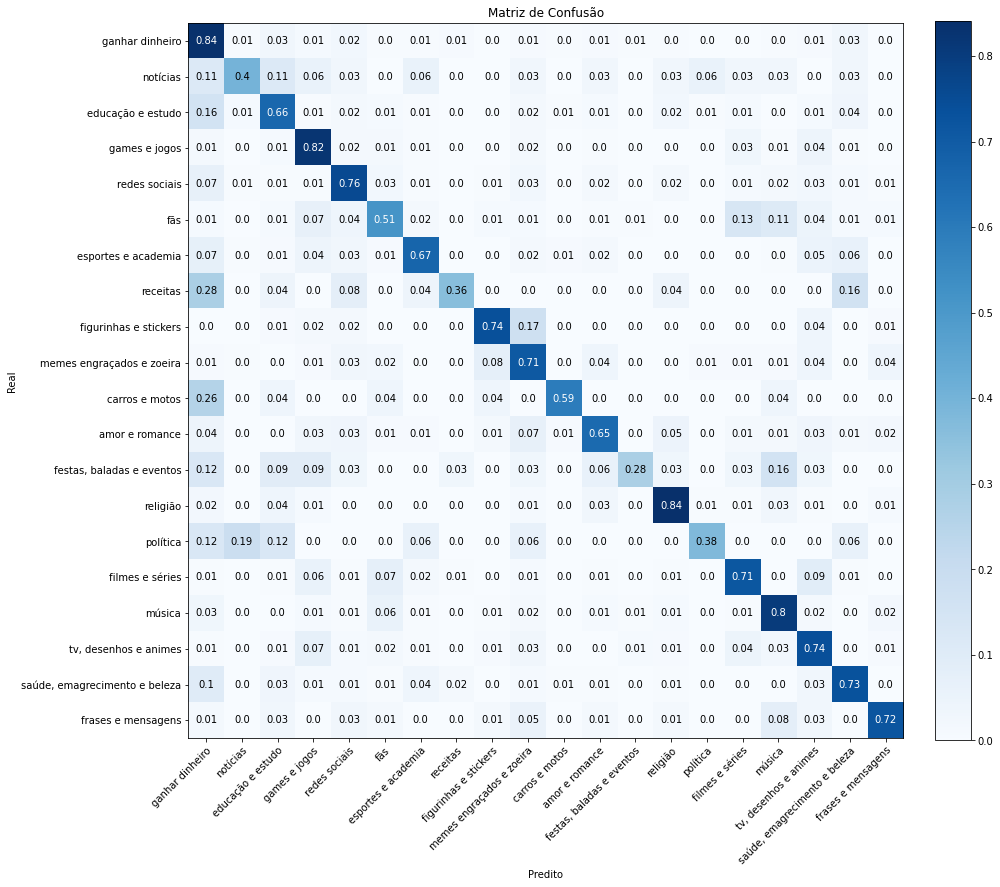

In [140]:
plot_confusion_matrix(model_logc, util.np_utils.to_categorical(pred, N_CLASSES), util.np_utils.to_categorical(np.array(labels)[t_index], N_CLASSES))

## Dataset 1: Treinamento LSTM

In [35]:
lstm_model_db1 = load_lstm()
lstm_model_db1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 100)           11888000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 85, 128)           84480     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10880)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                228501    
Total params: 12,200,981
Trainable params: 12,200,981
Non-trainable params: 0
_________________________________________________________________


In [141]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

i = 1
lstm_db1_accuracy = []
lstm_db1_macro_f1 = []
lstm_db1_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))       
    lstm_model_db1 = load_lstm()
    
    db1_lstm_training = lstm_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=8,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(lstm_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    lstm_db1_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

    i = i + 1

print("\nResultados:")  
if i > 1:  
  print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_accuracy)[0], calc_conf_interval(lstm_db1_accuracy)[3]))
  print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_macro_f1)[0], calc_conf_interval(lstm_db1_macro_f1)[3]))
  print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_wg_f1)[0], calc_conf_interval(lstm_db1_wg_f1)[3]))
else:
  print("Acurácia: ", sum(lstm_db1_accuracy)/i)
  print("Macro-F1: ", sum(lstm_db1_macro_f1)/i)
  print("Weighted-F1: ", sum(lstm_db1_wg_f1)/i)

1/5 - Folds

Train on 14284 samples, validate on 3571 samples
Epoch 1/8
14284/14284 [==============================] - 31s 2ms/step - loss: 2.6763 - acc: 0.3727 - val_loss: 2.0243 - val_acc: 0.4825
Epoch 2/8
14284/14284 [==============================] - 12s 828us/step - loss: 1.7770 - acc: 0.4971 - val_loss: 1.5108 - val_acc: 0.5587
Epoch 3/8
14284/14284 [==============================] - 10s 730us/step - loss: 1.2959 - acc: 0.6081 - val_loss: 1.3264 - val_acc: 0.6119
Epoch 4/8
14284/14284 [==============================] - 11s 742us/step - loss: 1.0203 - acc: 0.6811 - val_loss: 1.1884 - val_acc: 0.6544
Epoch 5/8
14284/14284 [==============================] - 11s 739us/step - loss: 0.8168 - acc: 0.7479 - val_loss: 1.1042 - val_acc: 0.6934
Epoch 6/8
14284/14284 [==============================] - 11s 766us/step - loss: 0.6559 - acc: 0.7906 - val_loss: 1.0700 - val_acc: 0.7082
Epoch 7/8
14284/14284 [==============================] - 11s 740us/step - loss: 0.5400 - acc: 0.8229 - val_loss:

## Dataset 1: Resultado LSTM

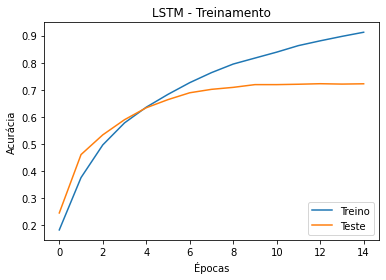

In [37]:
plot_training_performance(db1_lstm_training.history['acc'], db1_lstm_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 1: Treinamento CNN

In [42]:
cnn_model_db1 = load_cnn1d()
cnn_model_db1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 85, 100)           11888000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 85, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 21, 64)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 21, 20)            1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 20)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 420)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)              

In [109]:
i = 1

cnn_db1_accuracy = []
cnn_db1_macro_f1 = []
cnn_db1_wg_f1 = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))   
    cnn_model_db1 = load_cnn1d()
    
    db1_cnn_training = cnn_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=15,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(cnn_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    cnn_db1_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break
        
    i = i + 1
    

if i > 1:  
  print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_accuracy)[0], calc_conf_interval(cnn_db1_accuracy)[3]))
  print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_macro_f1)[0], calc_conf_interval(cnn_db1_macro_f1)[3]))
  print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_wg_f1)[0], calc_conf_interval(cnn_db1_wg_f1)[3]))
else:  
  print("\nResultados:")
  print("Acurácia: ", sum(cnn_db1_accuracy)/i)
  print("Macro-F1: ", sum(cnn_db1_macro_f1)/i)
  print("Weighted-F1: ", sum(cnn_db1_wg_f1)/i)

1/5 - Folds

Train on 14284 samples, validate on 3571 samples
Epoch 1/15
14284/14284 [==============================] - 4s 299us/step - loss: 3.0343 - acc: 0.0580 - val_loss: 2.9931 - val_acc: 0.1168
Epoch 2/15
14284/14284 [==============================] - 4s 260us/step - loss: 2.9556 - acc: 0.1629 - val_loss: 2.8875 - val_acc: 0.2131
Epoch 3/15
14284/14284 [==============================] - 4s 255us/step - loss: 2.7815 - acc: 0.2141 - val_loss: 2.6164 - val_acc: 0.2487
Epoch 4/15
14284/14284 [==============================] - 3s 235us/step - loss: 2.4041 - acc: 0.2745 - val_loss: 2.1656 - val_acc: 0.3394
Epoch 5/15
14284/14284 [==============================] - 3s 236us/step - loss: 2.0342 - acc: 0.3706 - val_loss: 1.8909 - val_acc: 0.4226
Epoch 6/15
14284/14284 [==============================] - 3s 237us/step - loss: 1.7027 - acc: 0.4581 - val_loss: 1.6882 - val_acc: 0.4719
Epoch 7/15
14284/14284 [==============================] - 3s 235us/step - loss: 1.4526 - acc: 0.5240 - val_los

## Dataset 1: Resultado CNN

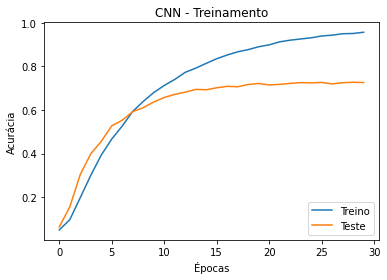

In [520]:
plot_training_performance(db1_cnn_training.history['acc'], db1_cnn_training.history['val_acc'], "CNN - Treinamento")

## Dataset 1: Matriz de Confusão do Melhor Modelo

In [142]:
results = lstm_model_db1.predict(SENTENCES_BASE1[test_index])

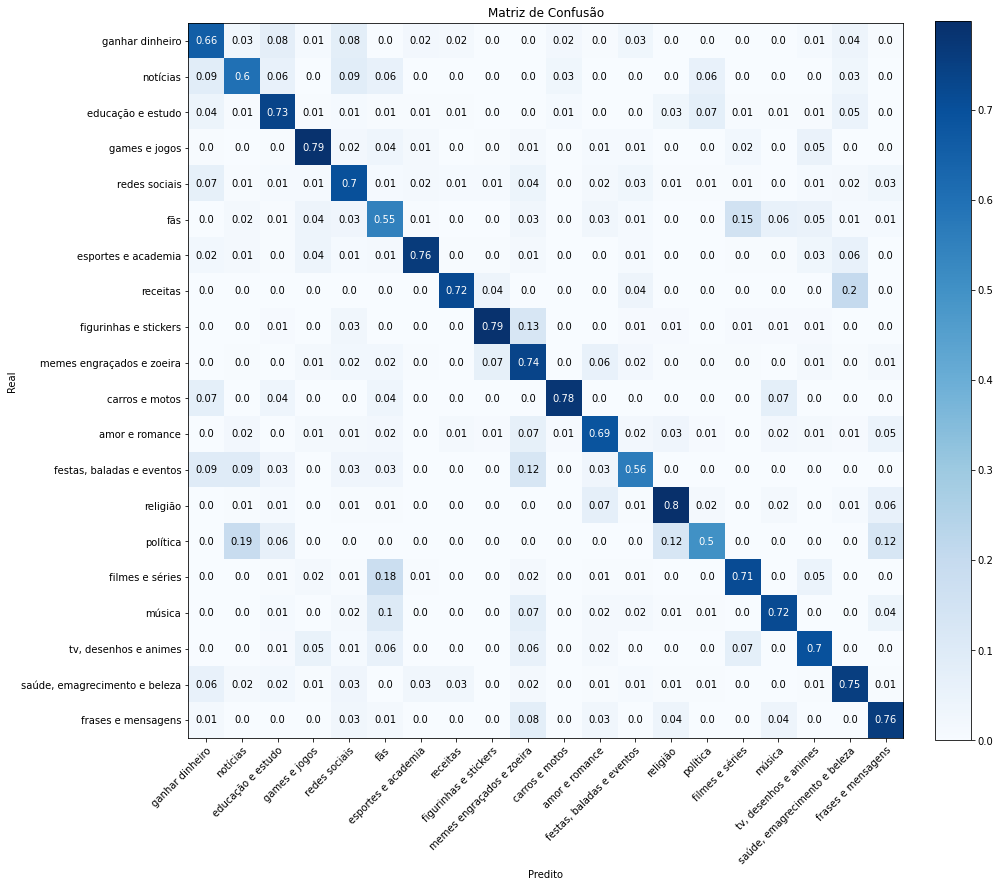

In [143]:
plot_confusion_matrix(lstm_model_db1, results, CATEGORY_BASE1[test_index])

## Dataset 1: Precisão das Classes

In [144]:
y_true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
y_pred = np.argmax(results, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       549
           1       0.35      0.60      0.44        35
           2       0.65      0.73      0.69       166
           3       0.88      0.79      0.83       481
           4       0.59      0.70      0.64       194
           5       0.46      0.55      0.50       179
           6       0.84      0.76      0.80       212
           7       0.47      0.72      0.57        25
           8       0.80      0.79      0.79       110
           9       0.61      0.74      0.67       212
          10       0.57      0.78      0.66        27
          11       0.64      0.69      0.66       147
          12       0.27      0.56      0.36        32
          13       0.87      0.80      0.83       189
          14       0.26      0.50      0.34        16
          15       0.66      0.71      0.69       189
          16       0.84      0.72      0.77       193
          17       0.79    

## Dataset 1: Principais Pontos

Adicionar pontos

# DATASET 2

Repetir os mesmos processos da etapa anterior

## Dataset 2: Treinamento Logistic Regression

In [527]:
labels = np.argmax(CATEGORY_BASE2, axis=1)
model_logc, t_index, result_train, result_test, macro_train, macro_test = execute_logistic_regression(list(df_base2['description']), labels, class_weights_db2)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("ACC Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
    print("Macro-F1 Treino: {} +- {:.2}".format(calc_conf_interval(macro_train)[0], calc_conf_interval(macro_train)[3]))
    print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(macro_test)[0], calc_conf_interval(macro_test)[3]))
else:
    print(np.mean(result_train))
    print(np.mean(result_test))
    print(macro_train)
    print(macro_test)


0.888168501938184
0.7283205268935236


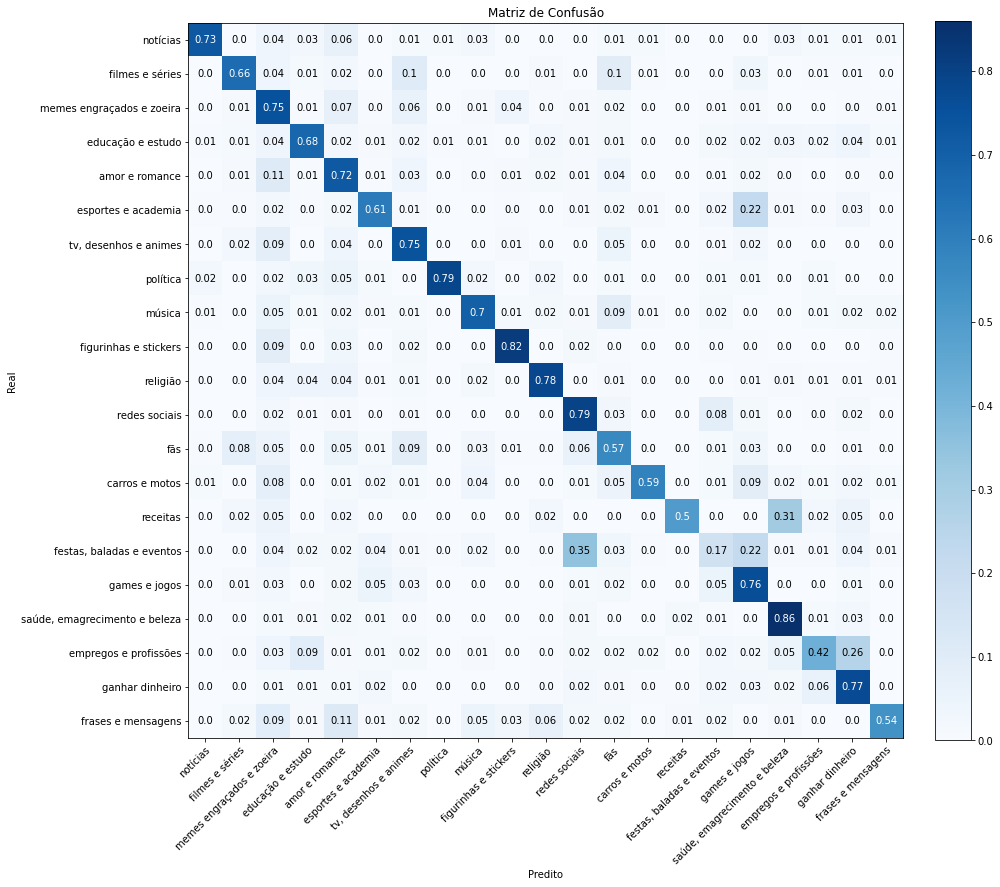

In [529]:
pred = model_logc.predict(np.array(df_base2['description']))[t_index]
plot_confusion_matrix(model_logc, util.np_utils.to_categorical(pred, 21), util.np_utils.to_categorical(np.array(labels)[t_index], 21))

## Dataset 2: Treinamento LSTM

In [530]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

In [ ]:
i = 1

lstm_db2_accuracy = []
lstm_db2_macro_f1 = []
lstm_db2_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))       
    lstm_model_db2 = load_lstm()
    
    db2_lstm_training = lstm_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=8,
        batch_size=2048, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(lstm_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    lstm_db2_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break


print("\nResultados:")  

if i > 1:  
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_accuracy)[0], calc_conf_interval(lstm_db2_accuracy)[3]))
    print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_macro_f1)[0], calc_conf_interval(lstm_db2_macro_f1)[3]))
    print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_wg_f1)[0], calc_conf_interval(lstm_db2_wg_f1)[3]))
else:     
    print("Acurácia: ", sum(lstm_db2_accuracy)/i)
    print("Macro-F1: ", sum(lstm_db2_macro_f1)/i)
    print("Weighted-F1: ", sum(lstm_db2_wg_f1)/i)

1/5 - Folds

Epoch 1/8
43/43 [==============================] - 40s 830ms/step - loss: 2.3033 - acc: 0.3883 - val_loss: 1.7039 - val_acc: 0.5221
Epoch 2/8
43/43 [==============================] - 33s 769ms/step - loss: 1.3569 - acc: 0.5859 - val_loss: 1.4081 - val_acc: 0.5985
Epoch 3/8
43/43 [==============================] - 33s 758ms/step - loss: 1.0579 - acc: 0.6556 - val_loss: 1.1996 - val_acc: 0.6617
Epoch 4/8
43/43 [==============================] - 33s 772ms/step - loss: 0.8834 - acc: 0.6977 - val_loss: 1.2568 - val_acc: 0.6389
Epoch 5/8
43/43 [==============================] - 33s 761ms/step - loss: 0.7513 - acc: 0.7283 - val_loss: 1.1376 - val_acc: 0.6674
Epoch 6/8
43/43 [==============================] - 33s 756ms/step - loss: 0.6262 - acc: 0.7681 - val_loss: 1.2135 - val_acc: 0.6479
Epoch 7/8
43/43 [==============================] - 33s 771ms/step - loss: 0.5321 - acc: 0.7954 - val_loss: 1.1290 - val_acc: 0.6861
Epoch 8/8
42/43 [============================>.] - ETA: 0s - lo

## Dataset 2: Resultado LSTM

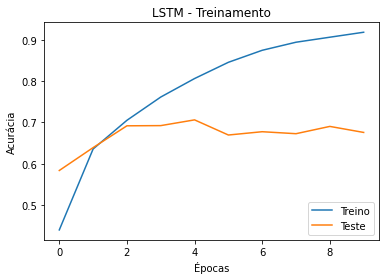

In [142]:
plot_training_performance(db2_lstm_training.history['acc'], db2_lstm_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 2: Treinamento CNN

In [448]:
i = 1

cnn_db2_accuracy = []
cnn_db2_macro_f1 = []
cnn_db2_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))   
    cnn_model_db2 = load_cnn1d()
    
    db2_cnn_training = cnn_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=30,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(cnn_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    cnn_db2_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

print("\nResultados:")

if i > 1:  
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_accuracy)[0], calc_conf_interval(cnn_db2_accuracy)[3]))
    print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_macro_f1)[0], calc_conf_interval(cnn_db2_macro_f1)[3]))
    print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_wg_f1)[0], calc_conf_interval(cnn_db2_wg_f1)[3]))
else:     
    print("Acurácia: ", sum(cnn_db2_accuracy)/i)
    print("Macro-F1: ", sum(cnn_db2_macro_f1)/i)
    print("Weighted-F1: ", sum(cnn_db2_wg_f1)/i)

1/5 - Folds

Epoch 1/20
43/43 [==============================] - 3s 41ms/step - loss: 2.9159 - acc: 0.1055 - val_loss: 2.7779 - val_acc: 0.2090
Epoch 2/20
43/43 [==============================] - 1s 35ms/step - loss: 2.3917 - acc: 0.2943 - val_loss: 2.0076 - val_acc: 0.4428
Epoch 3/20
43/43 [==============================] - 1s 35ms/step - loss: 1.7866 - acc: 0.4535 - val_loss: 1.6009 - val_acc: 0.5655
Epoch 4/20
43/43 [==============================] - 2s 35ms/step - loss: 1.4008 - acc: 0.5639 - val_loss: 1.4217 - val_acc: 0.6060
Epoch 5/20
43/43 [==============================] - 1s 35ms/step - loss: 1.1455 - acc: 0.6331 - val_loss: 1.2770 - val_acc: 0.6550
Epoch 6/20
43/43 [==============================] - 1s 35ms/step - loss: 0.9652 - acc: 0.6812 - val_loss: 1.2454 - val_acc: 0.6592
Epoch 7/20
43/43 [==============================] - 2s 35ms/step - loss: 0.8314 - acc: 0.7219 - val_loss: 1.1629 - val_acc: 0.6867
Epoch 8/20
43/43 [==============================] - 2s 35ms/step - los

## Dataset 2: Resultado CNN

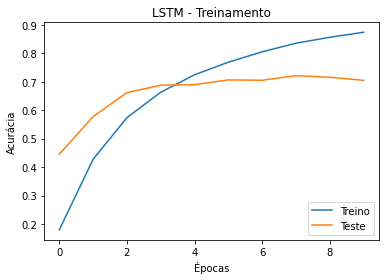

In [84]:
plot_training_performance(db2_cnn_training.history['acc'], db2_cnn_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 2: Matriz de Confusão do Melhor Modelo

In [449]:
results = cnn_model_db2.predict(SENTENCES_BASE2[test_index])

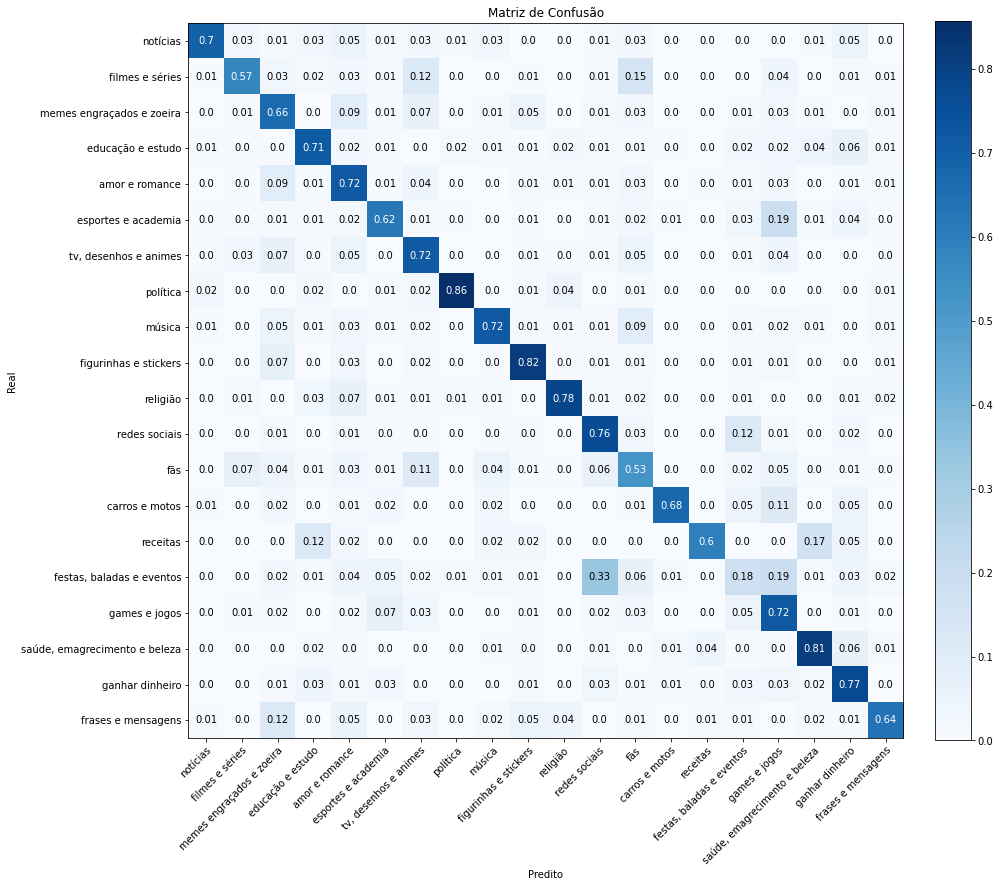

In [450]:
plot_confusion_matrix(cnn_model_db2, results, CATEGORY_BASE2[test_index])

## Dataset 2: Precisão das Classes

In [451]:
y_true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
y_pred = np.argmax(results, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.70      0.56        76
           1       0.46      0.57      0.51       385
           2       0.67      0.66      0.67      1905
           3       0.66      0.71      0.69       480
           4       0.51      0.72      0.60       891
           5       0.48      0.62      0.54       810
           6       0.75      0.72      0.73      2502
           7       0.64      0.86      0.73        98
           8       0.65      0.72      0.68       390
           9       0.79      0.82      0.80      1134
          10       0.78      0.78      0.78       320
          11       0.82      0.76      0.79      2694
          12       0.52      0.53      0.52      1306
          13       0.44      0.68      0.53        80
          14       0.34      0.60      0.43        42
          15       0.09      0.18      0.12       411
          16       0.87      0.72      0.79      5756
          17       0.82    

## Dataset 2: Principais Pontos

# AVALIANDO OS MODELOS EM BASES DIFERENTES

## Avaliando: Dataset 1 - Testando no Dataset 2

In [75]:
results = cnn_model_db1.predict(SENTENCES_BASE2)
y_true = np.argmax(CATEGORY_BASE2, axis=1)
y_pred = np.argmax(results, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.39      0.28       384
           1       0.45      0.47      0.46      1932
           2       0.35      0.61      0.45      9541
           3       0.70      0.52      0.60      2405
           4       0.22      0.67      0.33      4455
           5       0.49      0.55      0.52      4052
           6       0.63      0.61      0.62     12526
           7       0.53      0.02      0.04       490
           8       0.62      0.56      0.59      1959
           9       0.85      0.12      0.21      5684
          10       0.74      0.62      0.67      1606
          11       0.76      0.77      0.76     13482
          12       0.35      0.45      0.39      6540
          13       0.44      0.51      0.47       400
          14       0.42      0.31      0.36       211
          15       0.04      0.02      0.02      2068
          16       0.90      0.58      0.71     28795
          17       0.85    

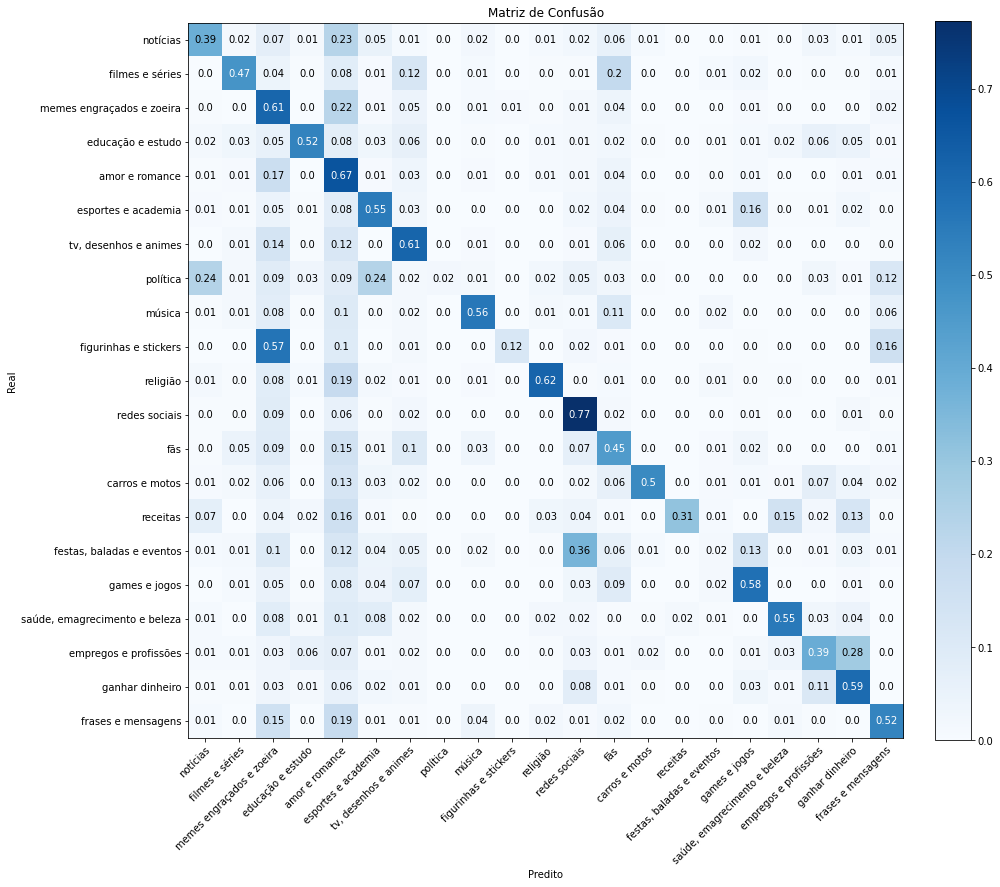

In [76]:
plot_confusion_matrix(cnn_model_db1, results, CATEGORY_BASE2)

## Avaliando: Dataset 2 - Testando no Dataset 1

In [88]:
results = cnn_model_db2.predict(SENTENCES_BASE1)
y_true = np.argmax(CATEGORY_BASE1, axis=1)
y_pred = np.argmax(results, axis=1)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.30      0.40       174
           1       0.57      0.64      0.60       929
           2       0.66      0.58      0.62      1053
           3       0.64      0.70      0.67       830
           4       0.65      0.63      0.64       727
           5       0.76      0.68      0.72      1060
           6       0.68      0.62      0.65      1786
           7       0.31      0.55      0.40        83
           8       0.75      0.75      0.75       953
           9       0.67      0.80      0.73       536
          10       0.87      0.79      0.83       935
          11       0.77      0.59      0.67       969
          12       0.40      0.58      0.47       896
          13       0.61      0.61      0.61       137
          14       0.50      0.40      0.44       124
          15       0.11      0.17      0.14       159
          16       0.84      0.74      0.79      2394
          17       0.66    

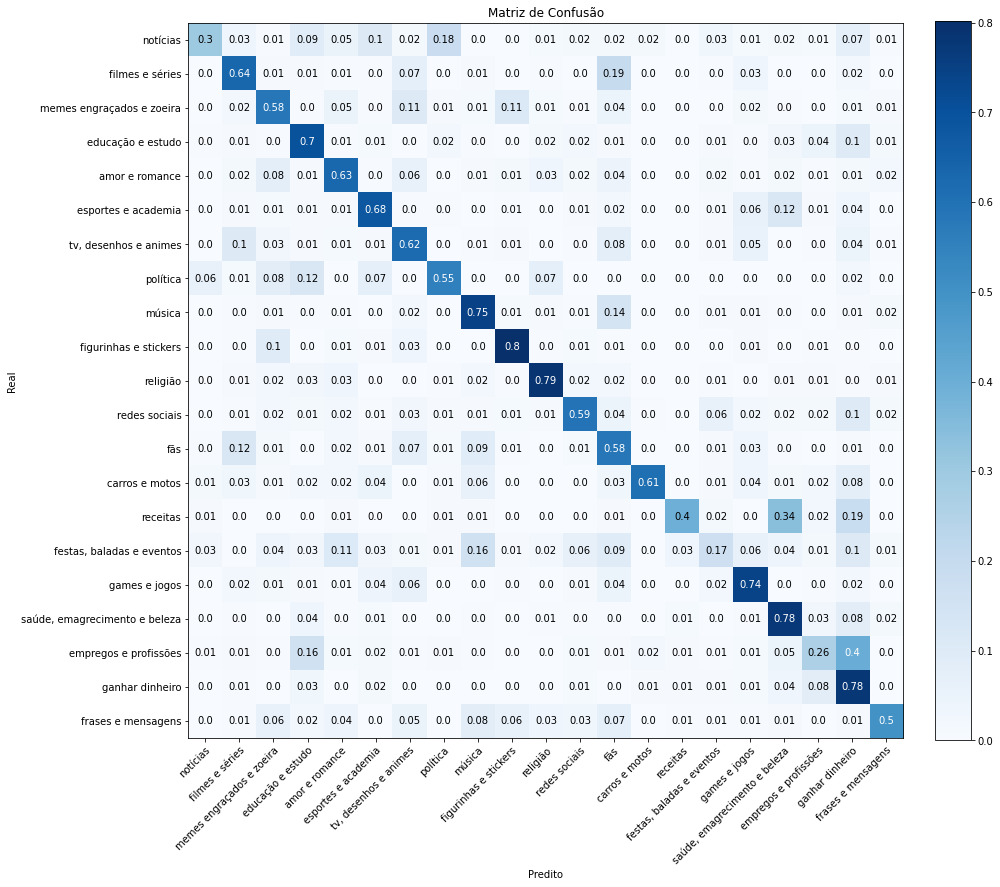

In [89]:
plot_confusion_matrix(lstm_model_db2, results, CATEGORY_BASE1)

## Principais Pontos

# CONCLUSÃO